In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import integrate
import time
import os
import sys
import astropy.units as u
from astropy.cosmology import Planck15 as cosmo
from colossus.cosmology import cosmology
sys.path.insert(0, '/work/08811/aew492/frontera/small-scale_cross-corrs')
from illustris_sim import TNGSim
import photxspec
import corrfuncs
import linear_theory
import tools
from spherex_xcorr import SPHERExXcorr

### loop through redshifts centered at $z=0.5$, $z=1$, $z=2$

In [4]:
# main inputs
snapshotss = [
    np.arange(25, 37),  # center at z=2.3
    np.arange(43, 58), # center at z=1.
    np.arange(62, 73) # center at z=0.5
]
# the 5 redshift error bins in SPHEREx
sigma_zs = [
    0.003,
    0.01,
    0.03,
    0.1,
    0.2
]

# instantiate spherex set for cross-correlation
X = SPHERExXcorr(snapshotss[0], sigma_zs[0], density_type='interpolated')

In [5]:
X.redshifts, np.mean(X.redshifts), len(X.redshifts)

(array([3.01, 2.9 , 2.73, 2.58, 2.44, 2.32, 2.21, 2.1 , 2.  , 1.9 , 1.82,
        1.74]),
 2.3124999999999996,
 12)

In [6]:
def run_xcorr(snapshots, sigma_z, density_type):
    
    print(f"running xcorr for snapshots {min(snapshots)}-{max(snapshots)}, sigma_z={sigma_z}")
    X = SPHERExXcorr(snapshots, sigma_z, density_type)
    X.construct_galaxy_samples()
    
    # plot number densities
    fig, ax = plt.subplots(figsize=(6,4), tight_layout=True)
    ax.plot(X.redshifts, X.target_number_densities, 'k.', alpha=0.8, label='From lookup table')
    ax.plot(X.redshifts, X.ns, 'k-', alpha=0.5, label='Interpolated')
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'Redshift $z$')
    ax.set_ylabel(r'Target number density (Mpc/$h)^{-3}$')
    ax.legend()
    ax.set_title(r'Target galaxy number densities with $\sigma_z=$'f'{sigma_z}: interpolation')
    
    # plot spectroscopic galaxies in each snapshot
    norm = mpl.colors.Normalize(vmin=min(X.redshifts), vmax=max(X.redshifts))
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
    fig, ax = plt.subplots(figsize=(15,2.6), tight_layout=True)
    for i, chi in enumerate(X.chis):
        gal_pos_spec_ = np.copy(X.gal_pos_specs[i])
        gal_pos_spec_[:,2] += chi
        kwargs = dict(c=smap.to_rgba(X.redshifts[i]), ls='None')
        ax.plot(gal_pos_spec_[:,2], gal_pos_spec_[:,0], marker=',', alpha=0.6, **kwargs)
        ax.plot(chi, 0, marker='o', c=smap.to_rgba(X.redshifts[i]), mec='k', zorder=100)
        ax.axvline((chi - X.boxsize/2).value, alpha=0.8, **kwargs)
        ax.axvline((chi + X.boxsize/2).value, alpha=0.8, **kwargs)
    ax.axhline(0, c='k', alpha=0.5, lw=0.5)
    ax.set_aspect('equal')
    ax.set_xlabel(r'LOS comoving distance $\chi$ (Mpc/h)')
    ax.set_ylabel(r'LOS $\perp$ (Mpc/h)')
    ax.set_title(f'{X.sim} snapshots, 'r'$\sigma_z=$'f'{sigma_z}')
    fig.colorbar(smap, ax=ax, label='Redshift $z$', pad=0.01)
    
    X.compute_angular_xcorrs(verbose=True)
    
    # save bias
    np.save(X.bias_fn, X.bias_dict)
    
    res = dict(chis=X.chis, central_chi=X.central_chi,
              theta_avg=X.theta_avg, wthetax=X.wthetax, wthetax_lin=X.wthetax_lin,
              redshifts=X.redshifts, dx=X.dx, sigma_z=X.sigma_z)
    
    print("")
    
    # plot the bias info
    fig, ax = plt.subplots(figsize=(8,5))
    norm = mpl.colors.Normalize(min(X.redshifts), max(X.redshifts))
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='turbo')
    for i, redshift in enumerate(X.redshifts):
        ax.plot(X.r_avg, X.bias_dict['biases_r'][i], marker='.', ls='-', c=smap.to_rgba(redshift), alpha=0.7)

    ax.axvspan(X.bias_dict['r_range'][0], X.bias_dict['r_range'][1], color='grey', alpha=0.2, label=f'Range for mean')
    ax.set_ylim(-.1, 4.5)
    ax.axhline(0, c='k', alpha=0.5, lw=0.5)
    ax.axhline(1, c='k', alpha=0.5, lw=0.5, ls='--')
    ax.semilogx()
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'separation $r$ (Mpc/h)')
    ax.set_ylabel(r'Bias $b(r)$')
    ax.set_title(f'Galaxy bias: 'r'$b(r) = \sqrt{\xi_\mathrm{Gal\,x\,Gal}(r)\,/\,\xi_\mathrm{lin}(r)}$')
    ax.legend()
    fig.colorbar(smap, ax=ax, label=r'Redshift $z$', pad=0.02)

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(X.redshifts, X.bias_dict['biases'], 'k.-', alpha=0.7)
    ax.grid(alpha=0.5, lw=0.5)
    ax.set_xlabel(r'Redshift $z$')
    ax.set_ylabel(r'Bias $b$')
    ax.set_title(r'Bias, $\sigma_z=$'f'{sigma_z}')
    
    return res

running xcorr for snapshots 25-36, sigma_z=0.003


/work/08811/aew492/frontera/small-scale_cross-corrs/corrfuncs.py:115: RuntimeWarning: Mean of empty slice
  wp = np.nanmean(wps, axis=0)  # get the mean across the runs


computing projected autocorr. from pair counts:	12 of 12 (z=1.74)
computing photometric weights
computing projected autocorr. from linear theory
loading bias results from /scratch1/08811/aew492/TNG300-3/bias/bias_z-1.74-3.01_sigmaz-0.003_ns_interp.npy

running xcorr for snapshots 25-36, sigma_z=0.01
computing projected autocorr. from pair counts:	12 of 12 (z=1.74)
computing photometric weights
computing projected autocorr. from linear theory
loading bias results from /scratch1/08811/aew492/TNG300-3/bias/bias_z-1.74-3.01_sigmaz-0.01_ns_interp.npy

running xcorr for snapshots 25-36, sigma_z=0.03
computing projected autocorr. from pair counts:	12 of 12 (z=1.74)
computing photometric weights
computing projected autocorr. from linear theory
loading bias results from /scratch1/08811/aew492/TNG300-3/bias/bias_z-1.74-3.01_sigmaz-0.03_ns_interp.npy

running xcorr for snapshots 25-36, sigma_z=0.1
computing projected autocorr. from pair counts:	12 of 12 (z=1.74)
computing photometric weights
comp

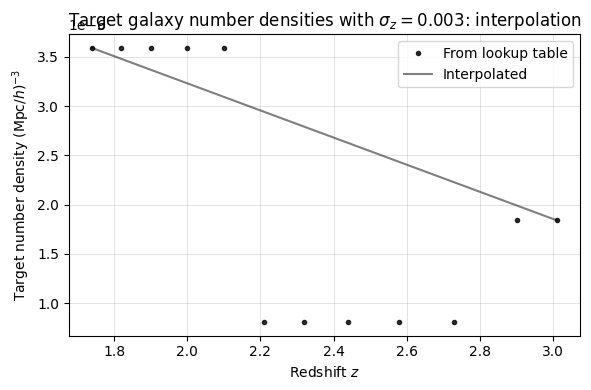

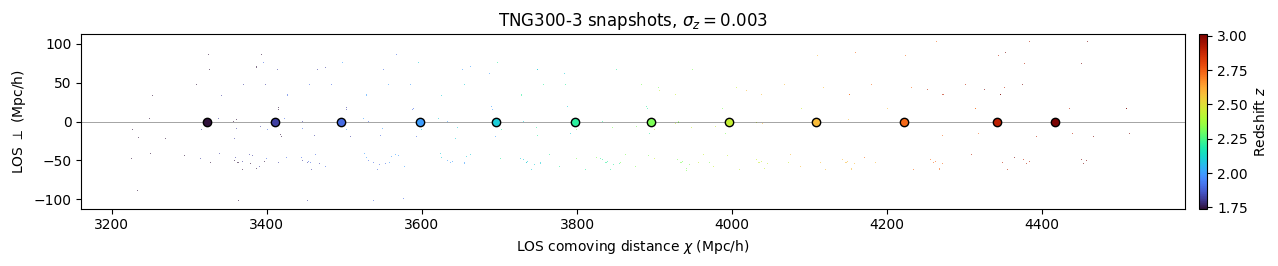

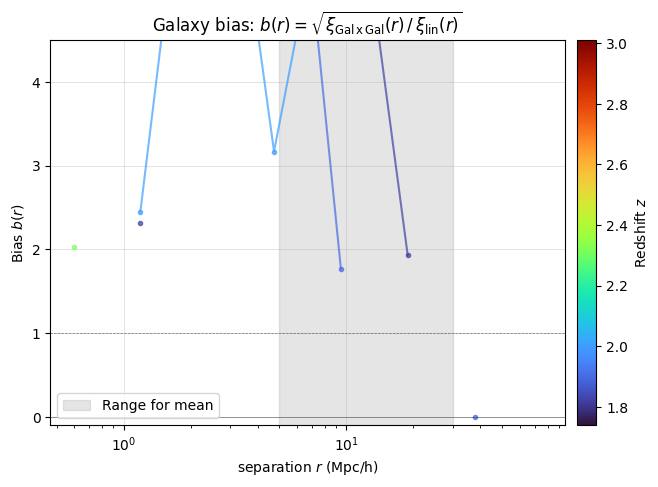

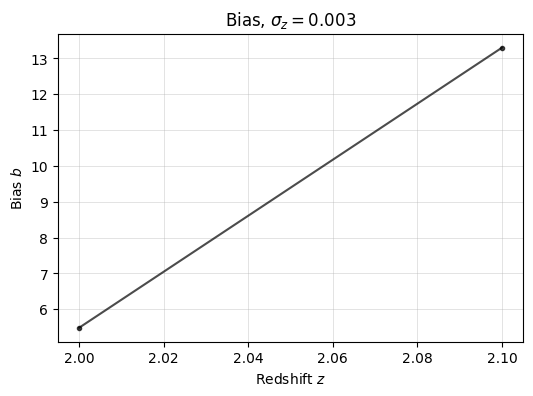

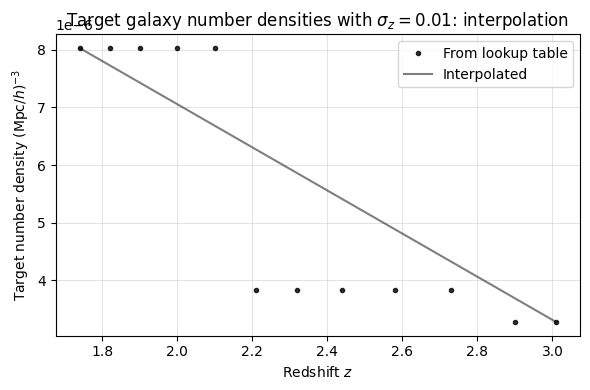

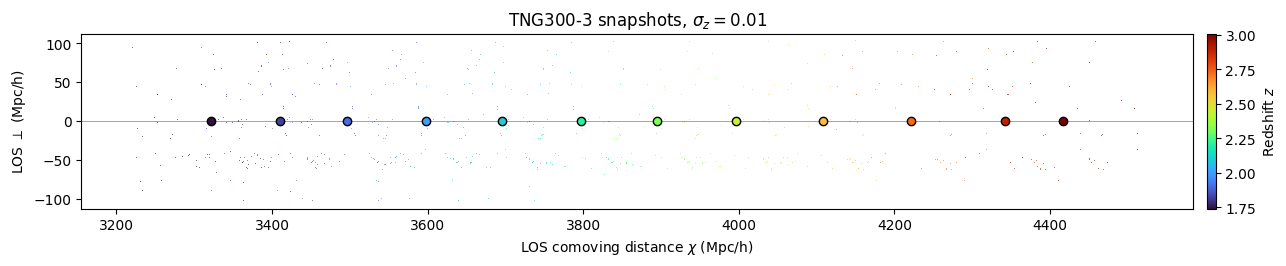

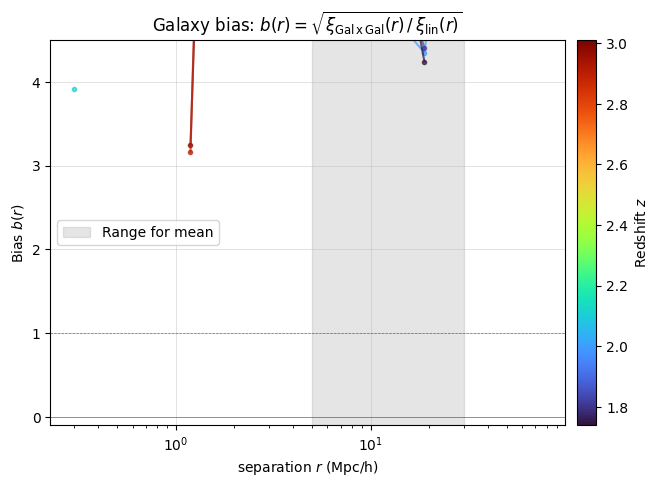

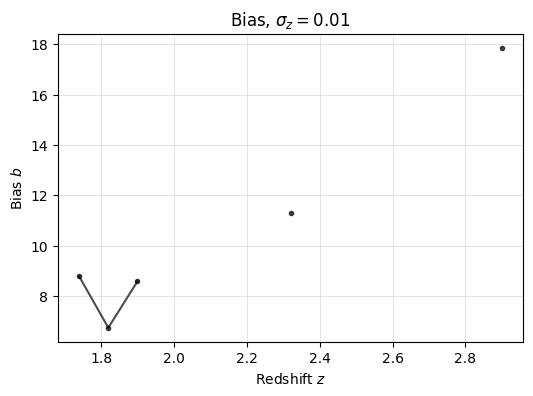

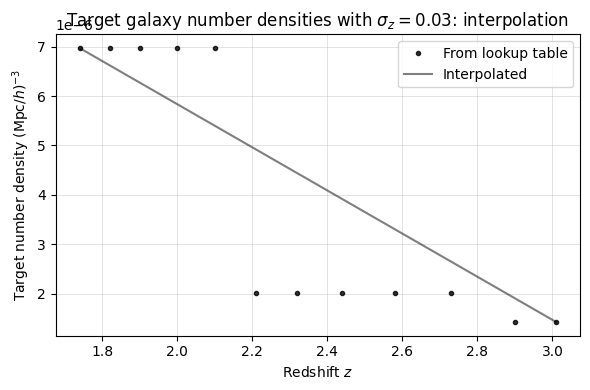

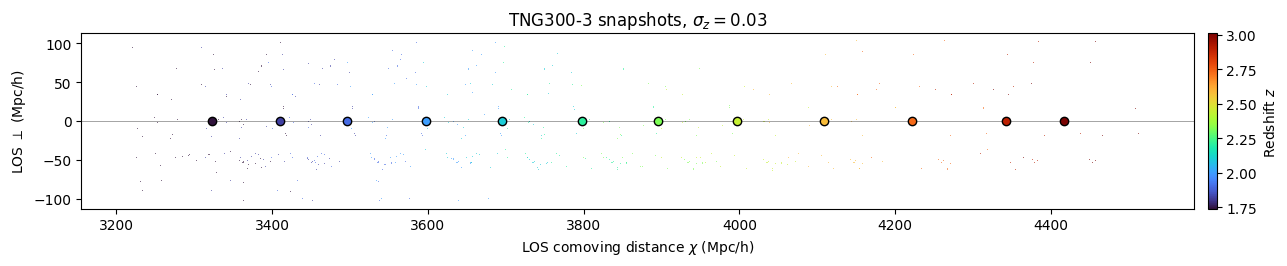

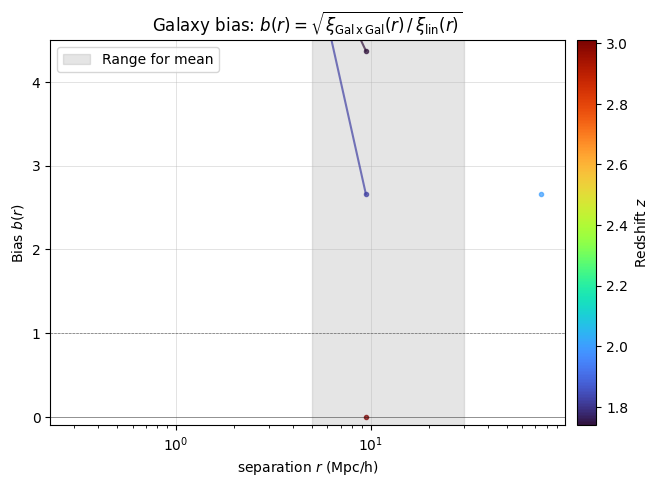

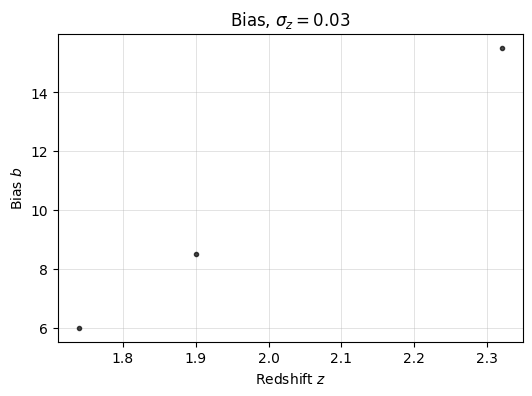

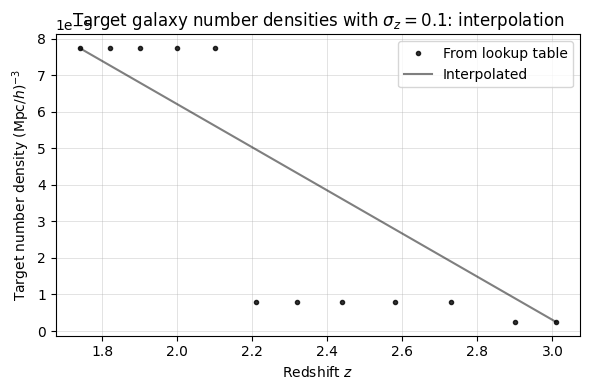

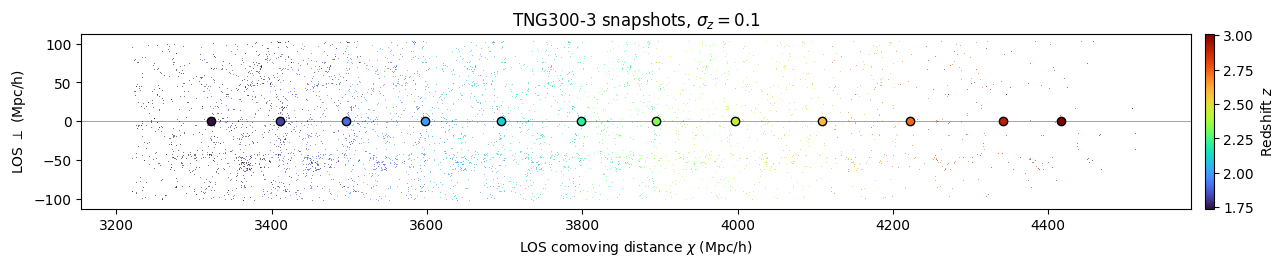

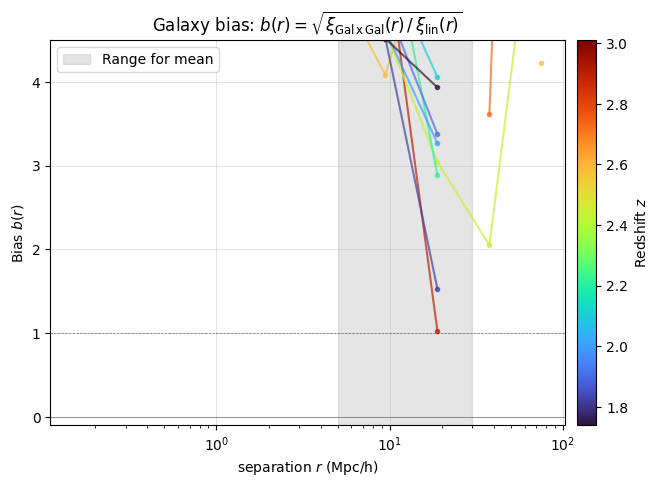

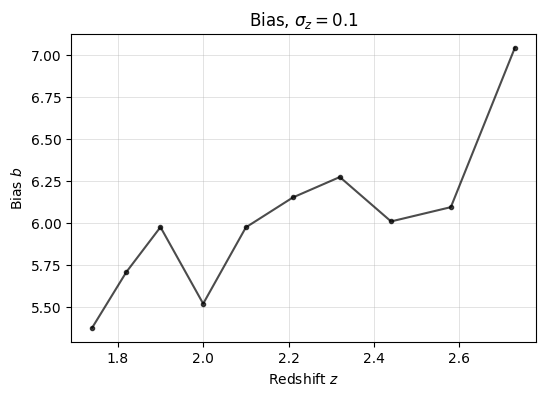

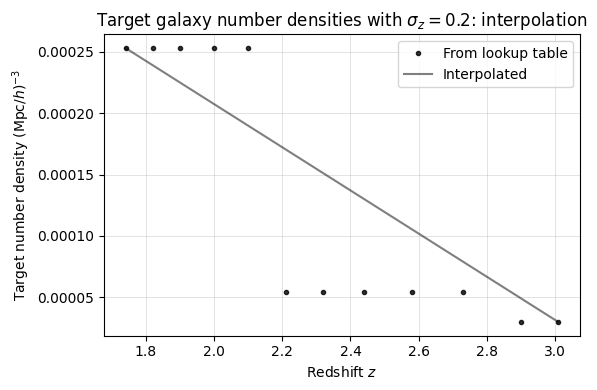

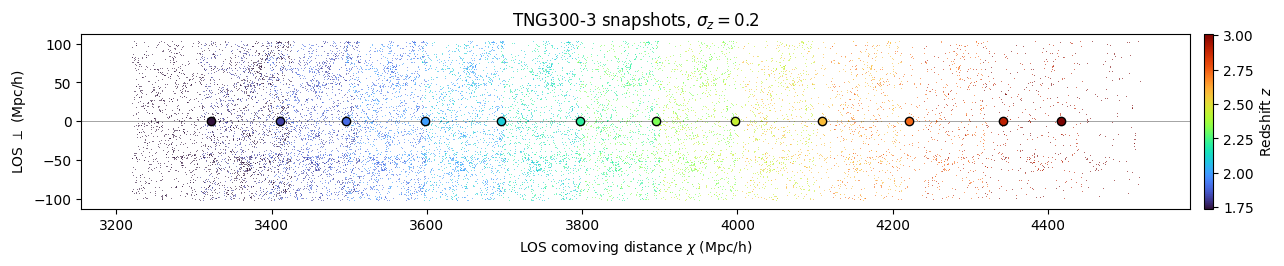

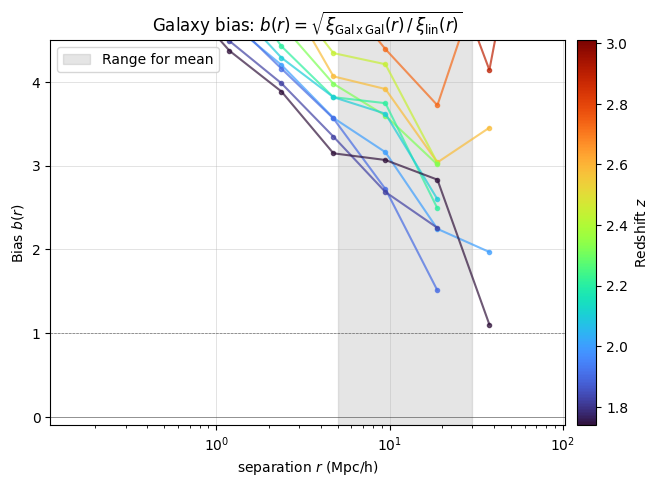

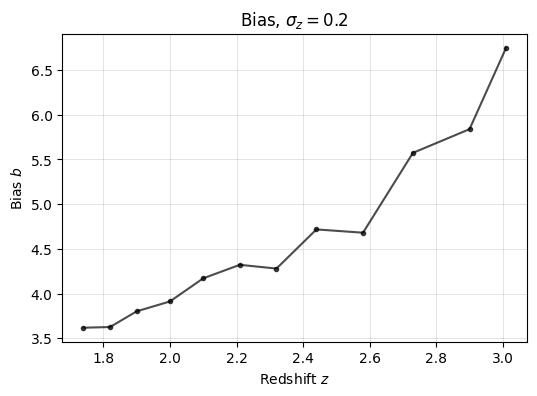

In [7]:
ress = []
for i, sigma_z in enumerate(sigma_zs):
    ress.append(run_xcorr(snapshotss[0], sigma_z, 'interpolated'))

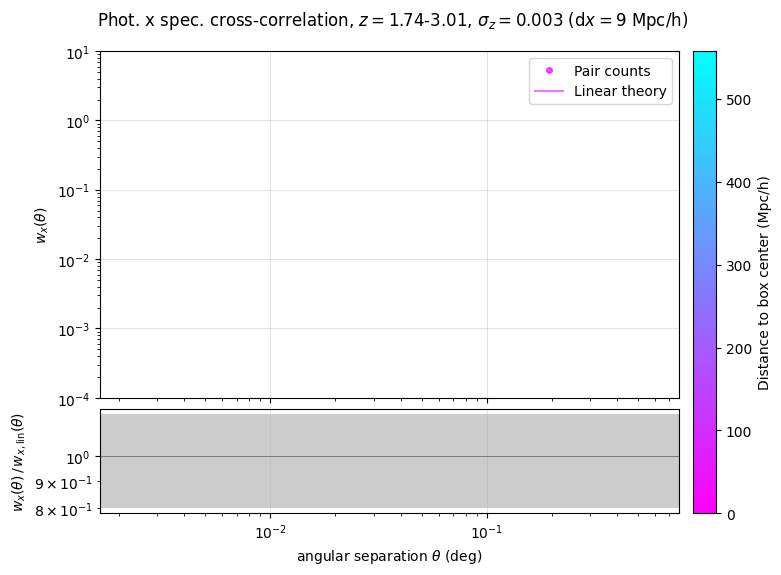

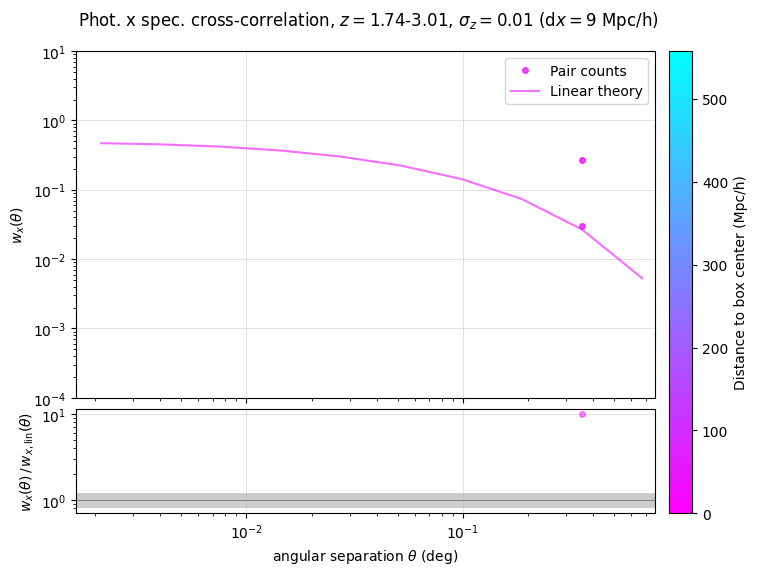

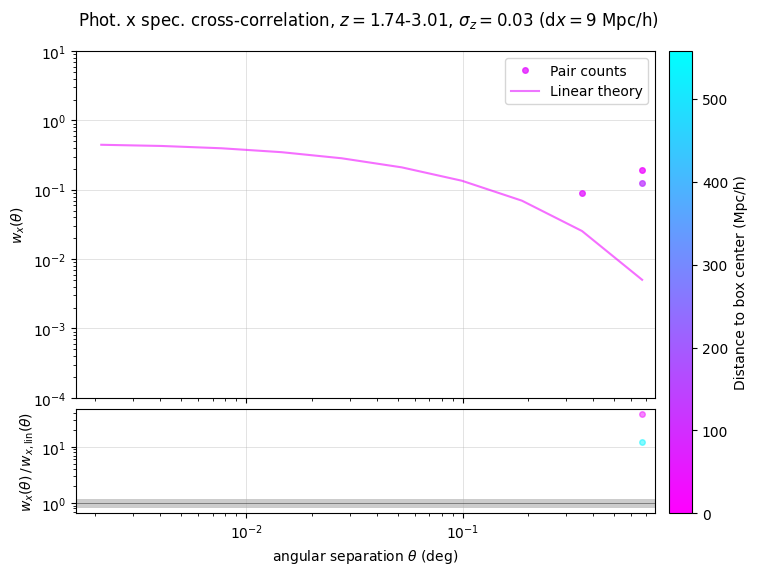

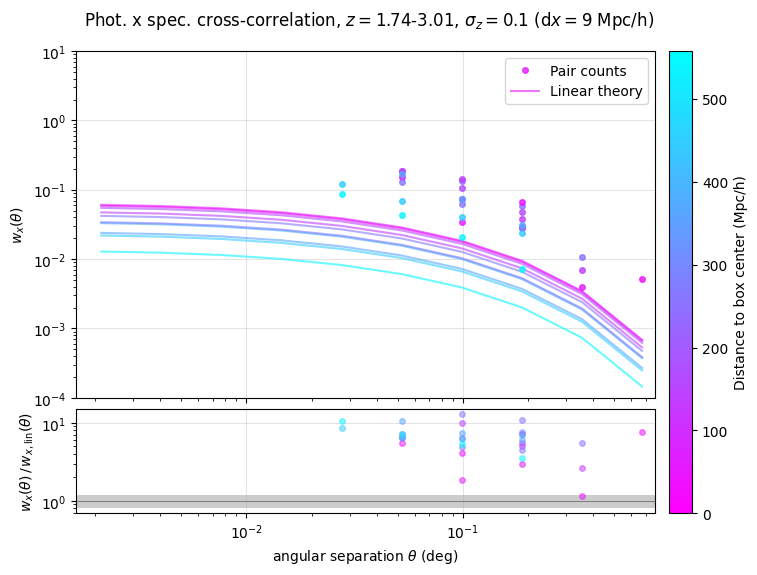

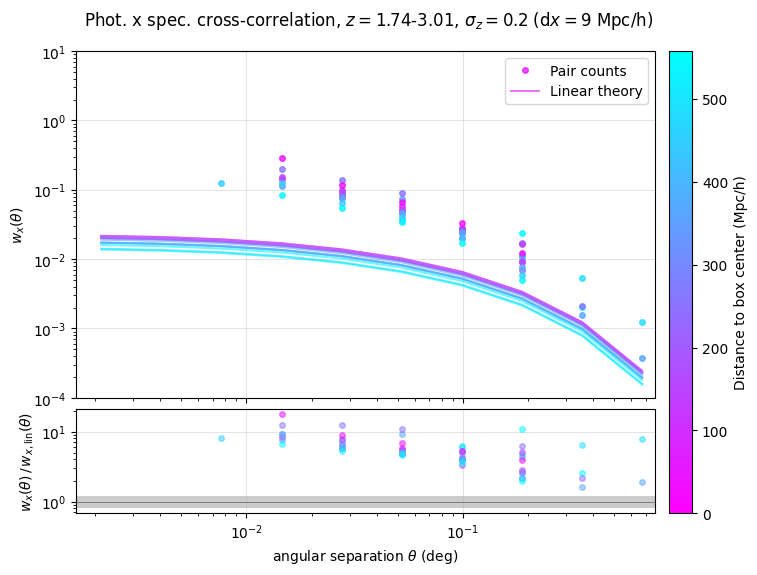

In [8]:
for i, res in enumerate(ress):
    
    chis = res['chis'].value
    central_chi = res['central_chi'].value
    theta_avg = res['theta_avg']
    wthetax = res['wthetax']
    wthetax_lin = res['wthetax_lin']
    redshifts = res['redshifts']
    dx = res['dx']
    sigma_z = res['sigma_z']
    
    # plot cross-correlation results
    norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis-central_chi)))
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
    fig = plt.figure(figsize=(9,6))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)

    ax0 = fig.add_subplot(gs[0])
    for i, w in enumerate(wthetax):
        kwargs = dict(c=smap.to_rgba(np.abs(chis[i] - central_chi)))
        label = 'Pair counts' if i==len(wthetax)//2 else ''
        ax0.plot(theta_avg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
        label = 'Linear theory' if i==len(wthetax)//2 else ''
        ax0.plot(theta_avg, wthetax_lin[i], alpha=0.6, label=label, **kwargs)
    # secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    # secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
    ax0.set_ylim(1e-4,1e1)
    ax0.set_ylabel(r'$w_x(\theta)$')
    ax0.legend()

    ax1 = fig.add_subplot(gs[1])
    ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
    for i, w in enumerate(wthetax):
        ax1.plot(theta_avg, w / wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
                 c=smap.to_rgba(np.abs(chis[i] - central_chi)))
    ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
    ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
    ax1.set_xlabel(r'angular separation $\theta$ (deg)')

    for ax in (ax0, ax1):
        ax.loglog()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(min(theta_avg)-5e-4, max(theta_avg)+1e-1)

    fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
    fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(redshifts)}-{max(redshifts)}, ' + \
                 r'$\sigma_z=$'f'{sigma_z} (d'r'$x=$'f'{X.dx.value:.0f} Mpc/h)',
                 x=0.45, y=0.95)

running xcorr for snapshots 43-57, sigma_z=0.003
computing projected autocorr. from pair counts:	15 of 15 (z=0.76)
computing photometric weights
computing projected autocorr. from linear theory
loading bias results from /scratch1/08811/aew492/TNG300-3/bias/bias_z-0.76-1.30_sigmaz-0.003_ns_interp.npy

running xcorr for snapshots 43-57, sigma_z=0.01
computing projected autocorr. from pair counts:	15 of 15 (z=0.76)
computing photometric weights
computing projected autocorr. from linear theory
loading bias results from /scratch1/08811/aew492/TNG300-3/bias/bias_z-0.76-1.30_sigmaz-0.01_ns_interp.npy

running xcorr for snapshots 43-57, sigma_z=0.03
computing projected autocorr. from pair counts:	15 of 15 (z=0.76)
computing photometric weights
computing projected autocorr. from linear theory
loading bias results from /scratch1/08811/aew492/TNG300-3/bias/bias_z-0.76-1.30_sigmaz-0.03_ns_interp.npy

running xcorr for snapshots 43-57, sigma_z=0.1
computing projected autocorr. from pair counts:	15 

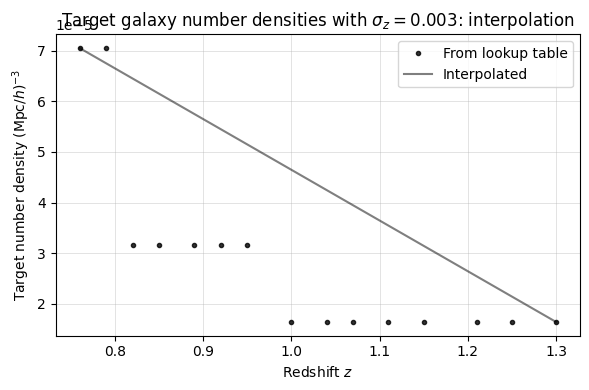

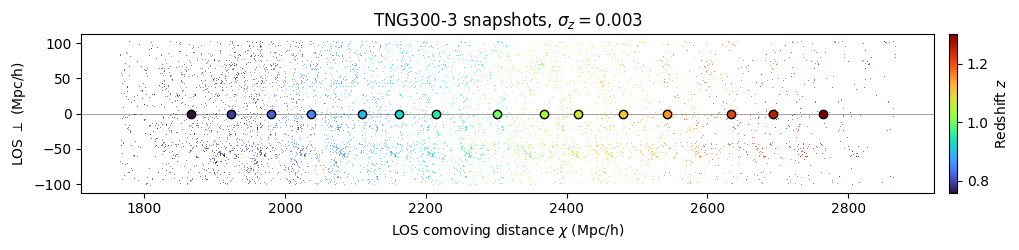

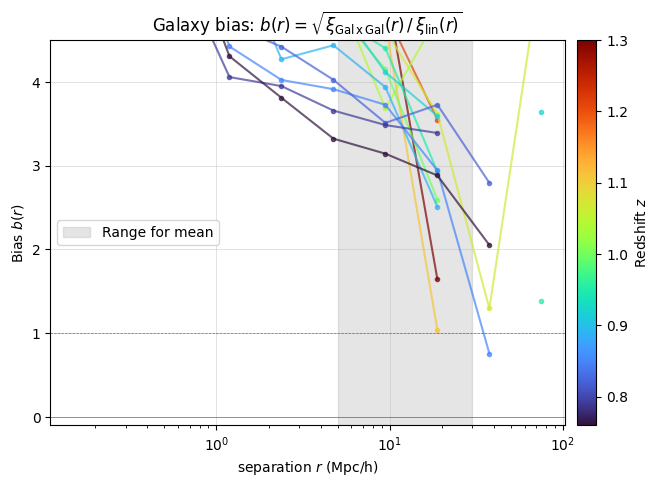

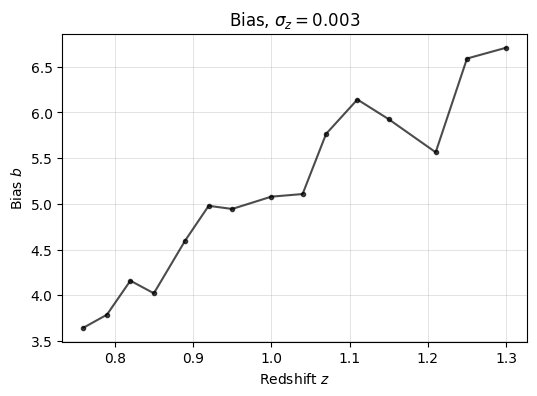

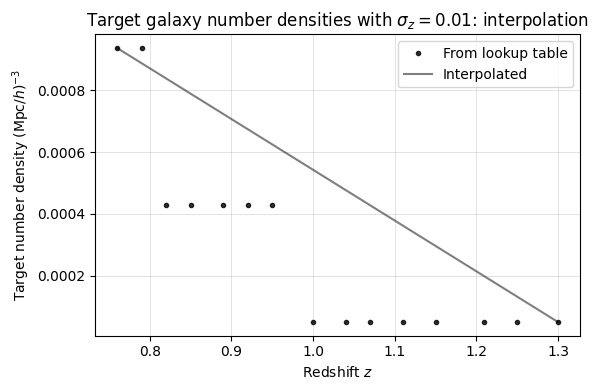

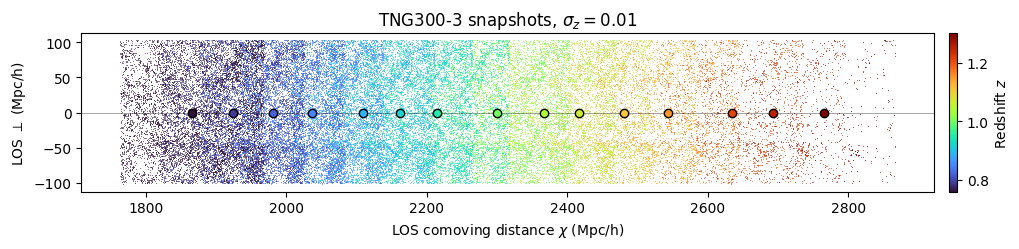

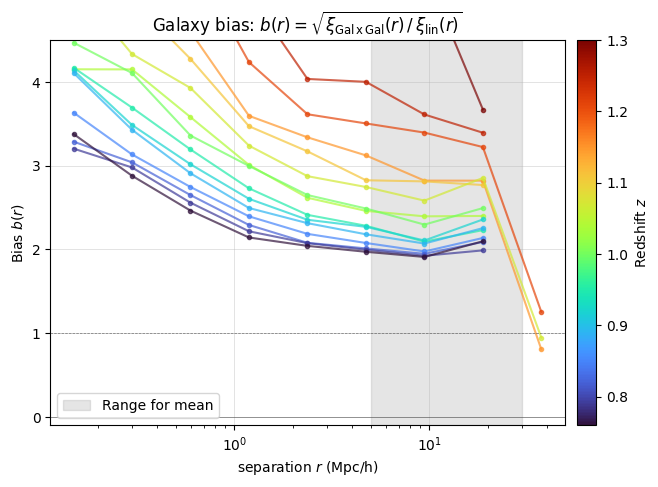

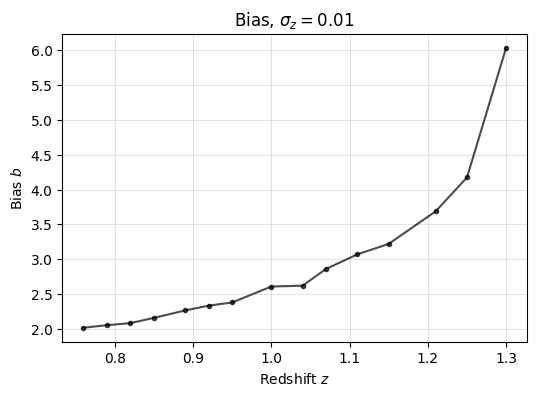

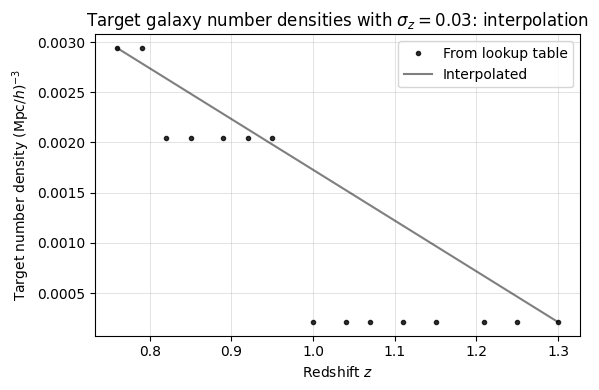

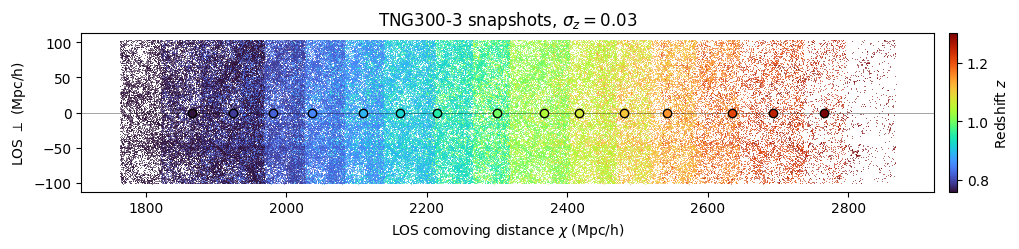

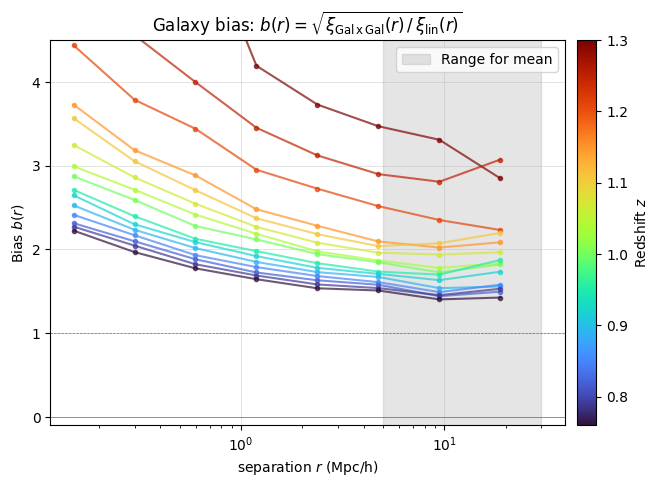

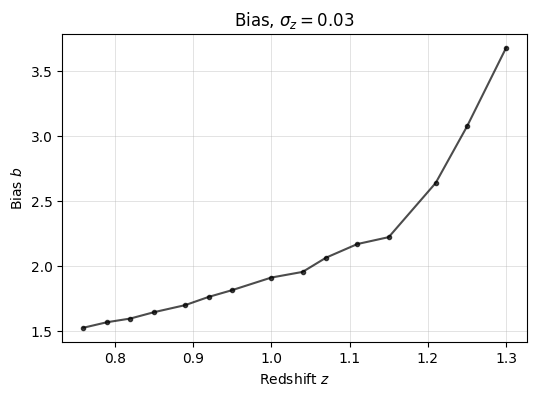

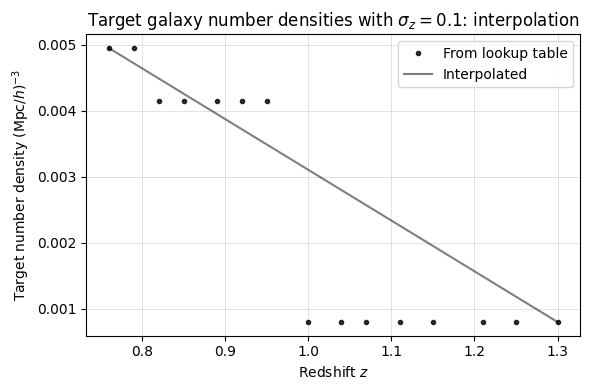

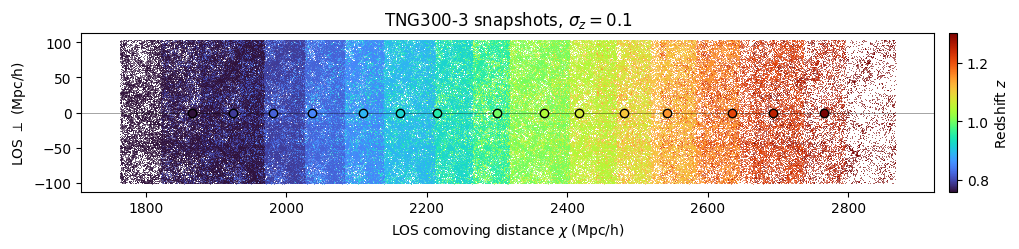

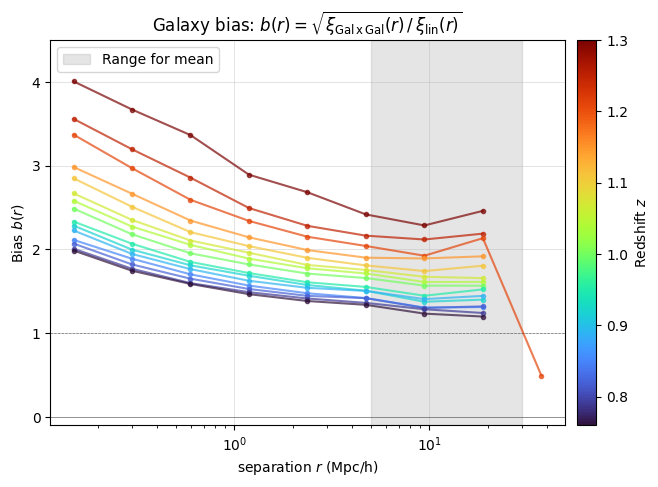

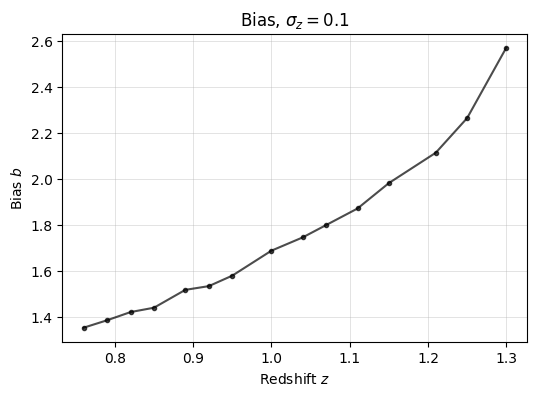

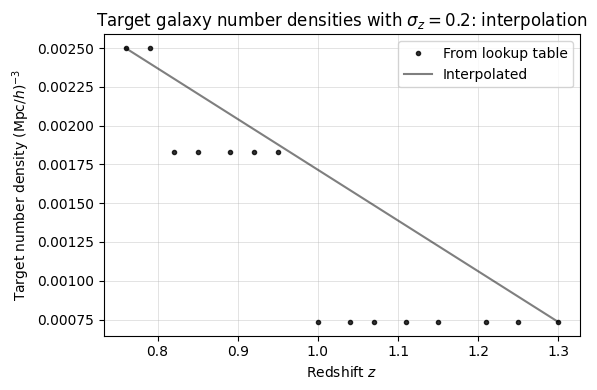

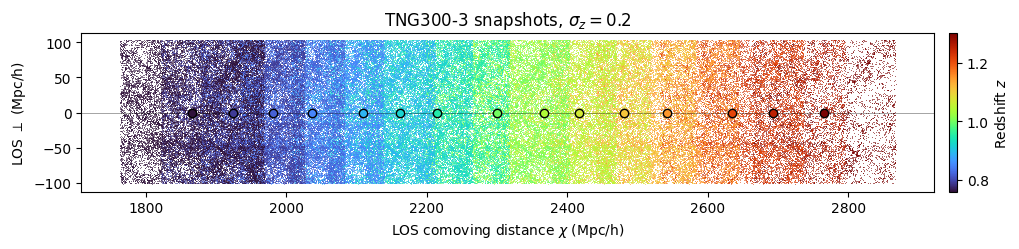

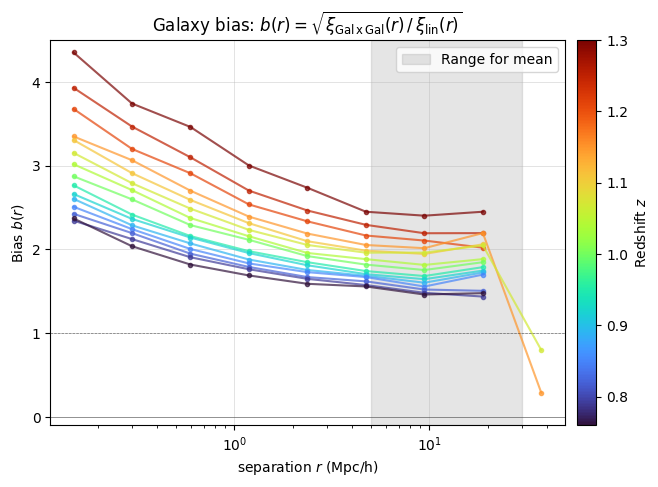

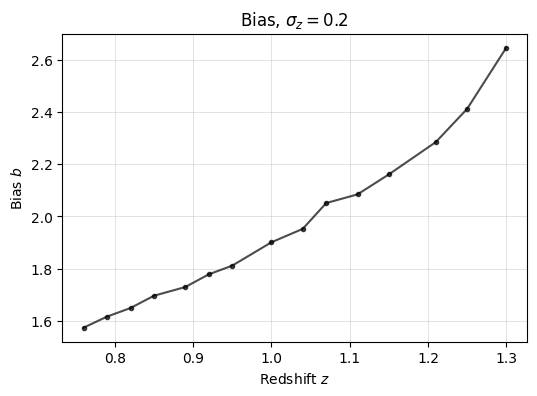

In [9]:
ress = []
for i, sigma_z in enumerate(sigma_zs):
    ress.append(run_xcorr(snapshotss[1], sigma_z, 'interpolated'))

/work/08811/aew492/frontera/venv/illustris/lib/python3.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: invalid value encountered in true_divide


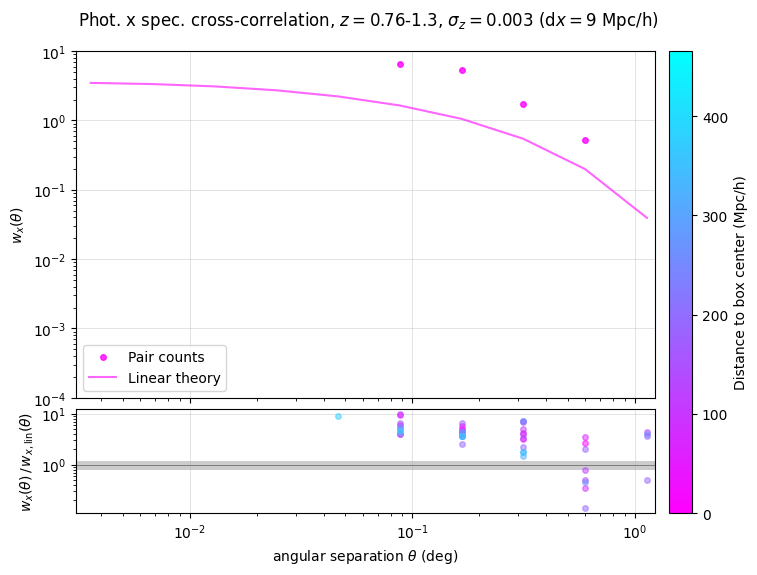

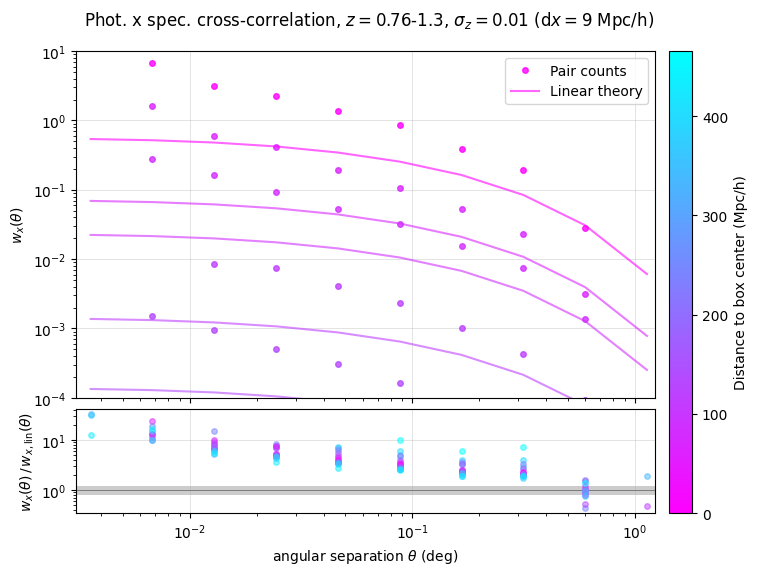

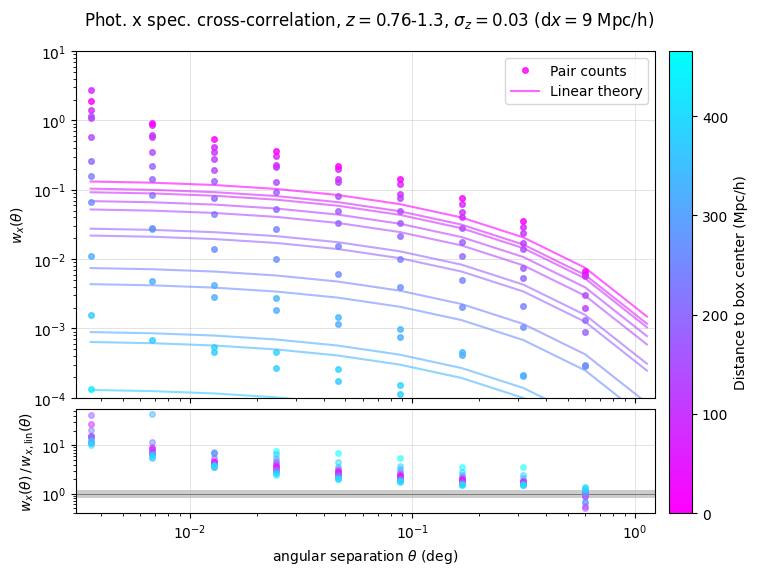

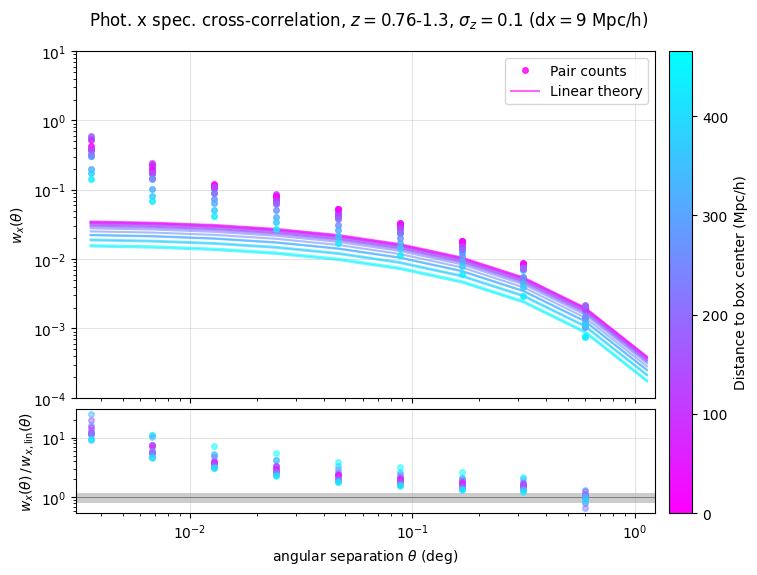

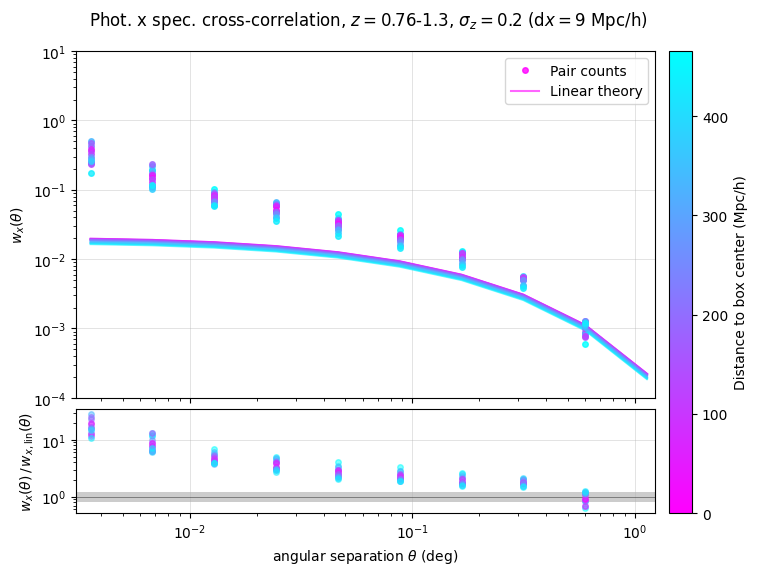

In [10]:
for i, res in enumerate(ress):
    
    chis = res['chis'].value
    central_chi = res['central_chi'].value
    theta_avg = res['theta_avg']
    wthetax = res['wthetax']
    wthetax_lin = res['wthetax_lin']
    redshifts = res['redshifts']
    dx = res['dx']
    sigma_z = res['sigma_z']
    
    # plot cross-correlation results
    norm = mpl.colors.Normalize(vmin=0, vmax=np.amax(np.abs(chis-central_chi)))
    smap = mpl.cm.ScalarMappable(norm=norm, cmap='cool_r')
    fig = plt.figure(figsize=(9,6))
    gs = mpl.gridspec.GridSpec(2, 1, height_ratios=[1,0.3], hspace=0.05)

    ax0 = fig.add_subplot(gs[0])
    for i, w in enumerate(wthetax):
        kwargs = dict(c=smap.to_rgba(np.abs(chis[i] - central_chi)))
        label = 'Pair counts' if i==len(wthetax)//2 else ''
        ax0.plot(theta_avg, w, marker='o', ms=4, ls='None', alpha=0.8, label=label, **kwargs)
        label = 'Linear theory' if i==len(wthetax)//2 else ''
        ax0.plot(theta_avg, wthetax_lin[i], alpha=0.6, label=label, **kwargs)
    # secax = ax0.secondary_xaxis('top', functions=(theta_to_r_comov_, r_comov_to_theta_))
    # secax.set_xlabel(r'separation $r_p$ (Mpc/h)')
    ax0.set_ylim(1e-4,1e1)
    ax0.set_ylabel(r'$w_x(\theta)$')
    ax0.legend()

    ax1 = fig.add_subplot(gs[1])
    ax1.axhline(1., c='k', alpha=0.5, lw=0.5)
    for i, w in enumerate(wthetax):
        ax1.plot(theta_avg, w / wthetax_lin[i], marker='o', ms=4, alpha=0.5, ls='None',
                 c=smap.to_rgba(np.abs(chis[i] - central_chi)))
    ax1.axhspan(0.8, 1.2, facecolor='k', alpha=0.2)
    ax1.set_ylabel(r'$w_x(\theta)\,/\,w_{x,\mathrm{lin}}(\theta)$')
    ax1.set_xlabel(r'angular separation $\theta$ (deg)')

    for ax in (ax0, ax1):
        ax.loglog()
        ax.grid(alpha=0.5, lw=0.5)
        ax.set_xlim(min(theta_avg)-5e-4, max(theta_avg)+1e-1)

    fig.colorbar(smap, ax=[ax0,ax1], label='Distance to box center (Mpc/h)', pad=0.02)
    fig.suptitle(r'Phot. x spec. cross-correlation, $z=$'f'{min(redshifts)}-{max(redshifts)}, ' + \
                 r'$\sigma_z=$'f'{sigma_z} (d'r'$x=$'f'{X.dx.value:.0f} Mpc/h)',
                 x=0.45, y=0.95)

In [11]:
ress = []
for i, sigma_z in enumerate(sigma_zs):
    ress.append(run_xcorr(snapshotss[2], sigma_z, 'interpolated'))

running xcorr for snapshots 62-72, sigma_z=0.003


AssertionError: snapshot not found